(Note that all units unless otherwise mentioned are SI units.)

In [1]:
import numpy as np
from skimage import io
from skimage.restoration import unwrap_phase
import prop
import matplotlib.pyplot as plt
import pickle
import prop
from tqdm import tqdm, trange
import time

Importing all the required libraries.

step_xy 1.00010001e-08
energy(in eV) 5000
wavelength in m 2.47968e-10
focal_length 0.006
zp_coords (-50, 50, -50, 50)
delta 0.00012143
beta 2.6233e-05


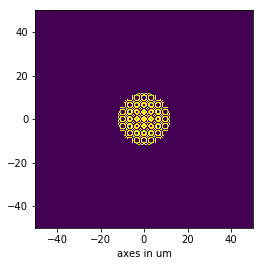

In [2]:
zp = np.load('zp.npy')
parameters = pickle.load(open('parameters.pickle','rb'))
for i in parameters : print(i,parameters[i])
zp_coords = parameters['zp_coords']
plt.imshow(zp,extent=zp_coords)
plt.xlabel('axes in um')
plt.show()

Importing zone plate pattern and the parameters associated with it.

In [3]:
'''
decide whether to use TF or IR approach depending on the distance
'''
def decide(step_z,step_xy,L,wavel):
    dist = step_z
    sampling = step_xy
    critical = wavel*dist/L
    if sampling > critical :
        p = prop.propTF
        print('propogator to be used : TF')
    else :
        p = prop.propIR
        print('propogator to be used : IR')
    return p   
'''
used as part of the multislice loop
'''
def modify(wavefront,zp_delta,zp_beta,step_z,wavel):
    dist = step_z
    kz = 2 * np.pi * dist /wavel
    beta_slice = zp_beta
    delta_slice = zp_delta
    new_wavefront = wavefront * np.exp((kz * delta_slice) * 1j) * np.exp(-kz * beta_slice)
    return new_wavefront
'''
perform free space propogation using the method decided above
'''
def propogate(wavefront,step_xy,step_z,L,wavel,p):
    sampling = step_xy
    dist = step_z
    return p(wavefront,sampling,L,wavel,dist)

*decide* : decides whether TF or IR approach should be used for propogation
* *Inputs* : step size in z, step size in xy, support length, wavelength
* *Outputs* : propogator
    
*modify* : wavefront is modified according to the material present
* *Inputs* : wavefront, slice properties (here the zone plate),step size in z , wavelength
* *Outputs* : modified wavefront

*propogate* : wavefront is propogated for the specified distance
* *Inputs* : wavefront, step size in z, step size in xy, wavelength, propogator
* *Outputs* : wavefront at output plane


In [4]:
def plot_2d_complex(input_array,mode='linear',name='input_array',**kwargs):
    fig, (ax1,ax2) = plt.subplots(1,2)
    if 'coords' in kwargs:
        if mode == 'linear' : 
            im1 = ax1.imshow((np.abs(input_array)),extent = kwargs['coords'])
        if mode == 'log' :
            im1 = ax1.imshow(np.log((np.abs(input_array))),extent = kwargs['coords'])
        fig.colorbar(im1,ax = ax1)
        ax1.set_xlabel('axes in um')
        im2 = ax2.imshow(unwrap_phase(np.angle(input_array)),extent = kwargs['coords'])
        fig.subplots_adjust(right=1.75)
        ax2.set_xlabel('axes in um')
        fig.colorbar(im2,ax = ax2)
    else :
        if mode == 'linear' : 
            im1 = ax1.imshow((np.abs(input_array)))
        if mode == 'log' :
            im1 = ax1.imshow(np.log((np.abs(input_array))))
        fig.colorbar(im1,ax = ax1)
        ax1.set_xlabel('axes in um')
        im2 = ax2.imshow(unwrap_phase(np.angle(input_array)))
        fig.subplots_adjust(right=1.75)
        ax2.set_xlabel('axes in um')
        fig.colorbar(im2,ax = ax2) 
    plt.show()
    print('magnitude(in '+str(mode)+' scale)(left) and phase(right) of the '+str(name)+': ')
    print('maximum value of '+str(name)+': ',np.max(abs(input_array)))
    print('minimum value of '+str(name)+': ',np.min(abs(input_array)))
    print('location of maxima in '+str(name)+': ',np.where(abs(input_array)==np.max(abs(input_array))))

*plot_2d_complex* : function used to plot complex 2d array
* *Inputs* : input_array - input array to be plotted, name - name of the variable being plotted, mode - used to specify linear or log plot , coords - used to plot the boundaries
* *Outputs* : plots of magnitude and phase!

In [5]:
def propogate_through_zp(wavefront_input,zp_delta,zp_beta,zp_thickness,number_of_steps_zp,d1,d2):
    
    wavefront = np.copy(wavefront_input)
    
    #pre zone plate
    if d1!= 0 :
        print('Free space propogation ...')
        step_z = d1
        p = decide(step_z,step_xy,L,wavel)
        print('Fresnel Number :',((zp_coords[0]**2*1e-12)/(wavel*step_z)))
        wavefront  = p(wavefront,step_xy,L,wavel,step_z)
    
    
    #through zone plate
    step_z = zp_thickness/number_of_steps_zp
    p = decide(step_z,step_xy,L,wavel)
    time.sleep(1)
    for i in tqdm(range(number_of_steps_zp),desc='ZP propogation ... '):
        wavefront = modify(wavefront,zp_delta,zp_beta,step_z,wavel)
        wavefront  = p(wavefront,step_xy,L,wavel,step_z)
    
    #post zone plate
    if d2!=0 :
        step_z = d2
        print('Free space propogation ...')
        p = decide(step_z,step_xy,L,wavel)
        print('Fresnel Number :',((zp_coords[0]**2*1e-12)/(wavel*step_z)))
        wavefront  = p(wavefront,step_xy,L,wavel,step_z)
    
    wavefront_out = np.copy(wavefront)
    return wavefront_out

*propogate_throguh_zp* : function used to propogate through zone plate
* *Inputs* : wavefront - input wave, zp_delta,zp_beta - zone plate, zp_thickness - thickness of zone plate, number_of_steps_zp - number of steps for propogation through zp, d1 - propogation distance before zp, d2 - propogation distance after zp
* *Outputs* : wavefront - output wave

In [6]:
zp_beta  = parameters['beta']*zp
zp_delta = parameters['delta']*zp
step_xy = parameters['step_xy']
energy = parameters['energy(in eV)']
wavel = parameters['wavelength in m']
f = parameters['focal_length']
wavefront = np.ones(np.shape(zp),dtype='complex64') 
L = step_xy*np.shape(zp)[0] 
m,n = np.shape(zp)
zp_thickness = 1000e-9      

*Setting up the parameters for the simulation*<br>
* *zp_beta and zp_delta* : delta and beta grid for the zone plate <br>
* *step_xy*              : sampling in the xy plane<br>
* *wavel*                : wavelength<br>
* *f*                    : focal length<br>
* *wavefront*            : wavefront that is initialzed with magnitude of 1 and phase of 0<br>
* *L*                    : support length<br>
* *m,n*                  : dimensions of input zp<zp>
* *zp_thickness*         : thickness of zone plate <br>

In [7]:
eps1 = 0.1
eps2 = 0.1
delta_z_suggested = ((eps2*(step_xy**2))/(eps1**2*wavel))
number_of_steps_zp = int(np.ceil(zp_thickness/delta_z_suggested))+1
print('suggested step size :',delta_z_suggested)
print('number of steps required for propogation through the zone plate :',number_of_steps_zp)

suggested step size : 4.03358509971e-06
number of steps required for propogation through the zone plate : 2


Determining the step size in the z direction (direction of propogation) using the meteric described in *Optics Express Vol. 25, Issue 3, pp. 1831-1846*

In [8]:
wavefront = np.ones(np.shape(zp),dtype='complex64') #initialize wavefront 

In [ ]:
wavefront = propogate_through_zp(wavefront,zp_delta,zp_beta,zp_thickness,number_of_steps_zp,d1=0,d2=f)

propogator to be used : TF


ZP propogation ... : 100%|██████████| 2/2 [01:09<00:00, 34.87s/it]


Free space propogation ...
propogator to be used : IR
Fresnel Number : 1680.3243429259687


In [ ]:
plot_2d_complex(wavefront,mode='log',name='focal_plane',coords=zp_coords)

In [ ]:
x = np.linspace(zp_coords[0],zp_coords[1],n)
plt.plot(x,abs(wavefront)[5000,:])
plt.xlabel('axes in um')
plt.show()
print('slice in x-direction along the focal spot')